In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import glob as gb
import cv2
import keras
from keras.applications import imagenet_utils
from tensorflow.keras.optimizers import SGD,Adam

from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dropout, Input, Add,DepthwiseConv2D, Dense, Activation,SeparableConv1D,GlobalAveragePooling2D, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
from keras.preprocessing import image
from keras.initializers import glorot_uniform

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import itertools

#Model Graphs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

2024-02-18 12:43:50.361083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 12:43:50.361199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 12:43:50.490643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class DepthwiseSeparableConv2D(keras.layers.Layer):
    
    def __init__(self, filters, kernel_size):
        super(DepthwiseSeparableConv2D, self).__init__()
        self.depthwise = DepthwiseConv2D(kernel_size = kernel_size, padding = "same", activation = "relu")
        self.pointwise = Conv2D(filters = filters, kernel_size = (1, 1), activation ="relu")
 
    def call(self, input_tensor):
        x = self.depthwise(input_tensor)
        return self.pointwise(x)

In [3]:
train_path='/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training/'
test_path='/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Testing/'
val_path='/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Validation/'

In [4]:
traingen = tf.keras.preprocessing.image.ImageDataGenerator(
                     #rescale=1./255,
                    #rotation_range=45, 
                    #width_shift_range=.15, 
                    #height_shift_range=.15,
                    #horizontal_flip=True, 
                    #zoom_range=0.5
)
testgen = tf.keras.preprocessing.image.ImageDataGenerator(
#rescale=1./255
)
validgen =tf.keras.preprocessing.image.ImageDataGenerator(
    #rescale=1./255
)

In [5]:
train_ds=traingen.flow_from_directory(batch_size=32,directory=train_path,shuffle=True,
                                                 target_size=(224,224),class_mode='categorical',
                                      #classes=[dir for dir in os.listdir(train_path) if "Tomato" in dir]
                                     
                                     )
test_ds=traingen.flow_from_directory(batch_size=32,directory=test_path,shuffle=False,target_size=(224,224), 
                                                 class_mode='categorical',
                                                 
                                    
                                    )

val_ds=traingen.flow_from_directory(batch_size=32,directory=val_path,shuffle=True,target_size=(224,224), 
                                                 class_mode='categorical',
                                   )

Found 3251 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
Found 416 images belonging to 3 classes.


In [6]:
from keras import backend

In [7]:
def inceptionModuleA(x):
    
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    ##branch5x5 = conv2d_bn(branch5x5, 64, 5, 5) 2Seprated
    #branch5x5 = DepthwiseSeparableConv2D(16, (3, 3))(branch5x5)
    branch5x5 = DepthwiseSeparableConv2D(16, (4, 4))(branch5x5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    #branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    #branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)  1 Seprated
    #branch3x3dbl = DepthwiseSeparableConv2D( 32,( 3, 3))(branch3x3dbl)
    branch3x3dbl = DepthwiseSeparableConv2D( 32,( 4, 4))(branch3x3dbl)
    #branch3x3dbl = DepthwiseSeparableConv2D( 32,( 4, 4))(branch3x3dbl)

    #branch3x3dbl = DepthwiseSeparableConv2D( 32,( 4, 4))(branch3x3dbl)



    branch_pool = layers.MaxPooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=3,
        )
    return x

In [8]:
def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
 
    if backend.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = layers.Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        )(x)
    x = layers.Activation('relu', name=name)(x)
    return x

In [9]:
input = Input(shape =(224,224,3))

In [10]:
class DepthwiseSeparableConv2D(keras.layers.Layer):
    
    def __init__(self, filters, kernel_size):
        super(DepthwiseSeparableConv2D, self).__init__()
        self.depthwise = DepthwiseConv2D(kernel_size = kernel_size, padding = "same", activation = "relu")
        self.pointwise = Conv2D(filters = filters, kernel_size = (1, 1), activation ="relu")
 
    def call(self, input_tensor):
        x = self.depthwise(input_tensor)
        return self.pointwise(x)

In [11]:
class SequencePooling(layers.Layer):
    def __init__(self):
        super().__init__()
        self.attention = layers.Dense(1)

    def call(self, x):
        attention_weights = keras.activations(self.attention(x), axis=1)
        attention_weights = tf.transpose(attention_weights, axes=(0, 2, 1))
        weighted_representation = ktf.transpose(attention_weights, x)
        return keras.ops.squeeze(weighted_representation, -2)

In [12]:
x = Conv2D (filters =64,kernel_size =3, padding ='same', activation='relu')(input)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=3)(x)


x = inceptionModuleA(x)
x = inceptionModuleA(x)
x = inceptionModuleA(x)
x = inceptionModuleA(x)

x = inceptionModuleA(x)
x = inceptionModuleA(x)





x = layers.LayerNormalization(epsilon=1e-5)(x)


#x = SequencePooling()(x)


x = GlobalAveragePooling2D()(x)
x = Dense(128)(x)
x = Dropout(.2)(x)


output = Dense(units = 3, activation ='softmax')(x)

In [13]:
model = Model (inputs=input, outputs =output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 75, 75, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [15]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [16]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [17]:
from tensorflow.keras.callbacks import LearningRateScheduler
import math
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

In [18]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),optimizer = keras.optimizers.Adam()
,
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
)

In [19]:
history = model.fit(train_ds,validation_data=val_ds,batch_size=32,epochs=50,verbose=1)

Epoch 1/50


I0000 00:00:1708260258.427841      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


102/102 [==============================] - 51s 317ms/step - loss: 1.2241 - accuracy: 0.3528 - val_loss: 1.0715 - val_accuracy: 0.3918
Epoch 2/50
102/102 [==============================] - 28s 269ms/step - loss: 1.0817 - accuracy: 0.4122 - val_loss: 1.0323 - val_accuracy: 0.4495
Epoch 3/50
102/102 [==============================] - 28s 270ms/step - loss: 1.0116 - accuracy: 0.4768 - val_loss: 0.9839 - val_accuracy: 0.5120
Epoch 4/50
102/102 [==============================] - 28s 270ms/step - loss: 0.9255 - accuracy: 0.5515 - val_loss: 0.8653 - val_accuracy: 0.6058
Epoch 5/50
102/102 [==============================] - 28s 270ms/step - loss: 0.8697 - accuracy: 0.6121 - val_loss: 0.8642 - val_accuracy: 0.6178
Epoch 6/50
102/102 [==============================] - 28s 270ms/step - loss: 0.8605 - accuracy: 0.6164 - val_loss: 0.9265 - val_accuracy: 0.5000
Epoch 7/50
102/102 [==============================] - 28s 270ms/step - loss: 0.6603 - accuracy: 0.7287 - val_loss: 0.4607 - val_accuracy: 0.8

In [20]:
from tensorflow.keras.utils import to_categorical
y_pred = model.predict_generator(test_ds)
y_pred2= to_categorical(np.argmax(y_pred, axis=1), 3)

y_test= to_categorical(test_ds.labels, 3)

# Using it in AUC
y_pred1=(np.argmax(y_pred, axis=1))
y_test1=(np.argmax(y_test, axis=1))

In [21]:
import tensorflow
import tensorflow as tf
topn_test = np.argsort(y_pred, axis = 1)[:,-3:]
top_n_test=np.mean(np.array([1 if y_test1[k] in topn_test[k] else 0 for k in range(len(topn_test))]))

In [22]:
top_n_test

1.0

In [23]:
# Computing the Accuracy Score  : ((TP + TN) / float(TP + TN + FP + FN))
def Accuracy(y_test , y_pred):
    AccScore = accuracy_score(y_test, y_pred, normalize=True)
    return AccScore

In [24]:
#Computing the Precision metric (Some times called Specificity): #(True Positives / float(True Positives + False Posivites))  
def macro_precision(y_test , y_pred):
    PrecisionScore = precision_score(y_test, y_pred, average='macro') 
    return PrecisionScore

In [25]:
#Computing the Recall Score : (Some times called Sensitivity) (TP / float(TP + FN))   1 / 1+2  
def macro_recall(y_test , y_pred):
    RecallScore = recall_score(y_test, y_pred, average='macro') 
    return  RecallScore

In [26]:
#Computing the F1 Score  : 2 * (precision * recall) / (precision + recall)
def macro_F1Score(y_test , y_pred):
    F1Score = f1_score(y_test, y_pred, average='macro') 
    return F1Score

In [27]:
from sklearn.metrics import roc_auc_score

# Calculating Area under the curve
def AUC(actual_class, pred_class, average = "micro"):
    
    #Making a set of all the unique classes 
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #Making a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [28]:
print("***** Model Evaluations Details ******** \n")
print("Test loss, Test acc : " , model.evaluate_generator(test_ds)) 
print("******************************")
print("Accurayc  : " , Accuracy(test_ds.classes , y_pred1)) 
print("******************************")
print("Precision Score is : " , macro_precision(test_ds.classes , y_pred1))
print("******************************")
print("Recall Scores is : " , macro_recall(test_ds.classes , y_pred1))
print("******************************")
print('F1 Score is : ', macro_F1Score(test_ds.classes , y_pred1))
print("******************************")
print('AUC Score is : ' , AUC(test_ds.classes, y_pred1))

***** Model Evaluations Details ******** 

Test loss, Test acc :  [0.03192809224128723, 0.9851852059364319]
******************************
Accurayc  :  0.9851851851851852
******************************
Precision Score is :  0.9843412211510371
******************************
Recall Scores is :  0.9864285088871377
******************************
F1 Score is :  0.9852447139278544
******************************
AUC Score is :  {0: 0.9876543209876543, 1: 0.995049504950495, 2: 0.9858156028368794}


In [29]:
labels=["Class 0","Class 1","Class 2"]

In [30]:
labels=list(train_ds.class_indices.keys())

In [31]:
x

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dropout')>

In [32]:
from sklearn.metrics import classification_report

print(classification_report(test_ds.classes, y_pred1,target_names=labels))


              precision    recall  f1-score   support

Early_Blight       0.98      0.99      0.98       162
     Healthy       0.97      1.00      0.99       102
 Late_Blight       1.00      0.97      0.99       141

    accuracy                           0.99       405
   macro avg       0.98      0.99      0.99       405
weighted avg       0.99      0.99      0.99       405



In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.style.library['seaborn-whitegrid']

RcParams({'axes.axisbelow': True,
          'axes.edgecolor': '.8',
          'axes.facecolor': 'white',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 1.0,
          'figure.facecolor': 'white',
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial',
                              'Liberation Sans',
                              'DejaVu Sans',
                              'Bitstream Vera Sans',
                              'sans-serif'],
          'grid.color': '.8',
          'grid.linestyle': '-',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': <CapStyle.round: 'round'>,
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direct

In [34]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 12}
plt.rc('font', **font)

In [35]:
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [36]:
def plot_roc_curve(y_test,y_pred):
    n_classes=3
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

    plt.plot(fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)
    colors = cycle(["aqua", "darkorange", "cornflowerblue",'#9e9e9e','#b19a7e','#CD5C5C','#DFFF00',
                   '#DE3163','#ff4d4d','#CCCCFF','#800080','#4F1D25','#ccffcc','#ff0040'
                   ,'#4000ff','#0080ff','#ff8000','#666600','#b37700','#00b3b3','#003300','#FFC300','#A6F7BD',
                   '#A6BDF7','#CAA6F7','#F7A6AC','#ADF7A6','#F5F7A6','#F7CCA6','#EE4949',
                    '#DEA41F','#334471','#33716F','#343371','#772CE3','#B8BF20','#666B01','#0B6B01',
                    '#F4B708','#179690'
                   ])

    for i, color in zip(range(n_classes), colors):
        plt.plot(
           fpr[i],
           tpr[i],
           color=color,
           lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

In [37]:
def Acc_Loss_Graph(history):
    # converting hsitory to dataframe
    pd.DataFrame(history.history)

    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')

    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [38]:
labels=np.array(labels)

In [39]:
def Confusion_Matrix(y_test , y_pred):
    fig, ax = plt.subplots(figsize=(5,5))

    #cnf_matrix = confusion_matrix()
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=labels,ax=ax,xticks_rotation='vertical'
                                                  ,cmap="Blues")

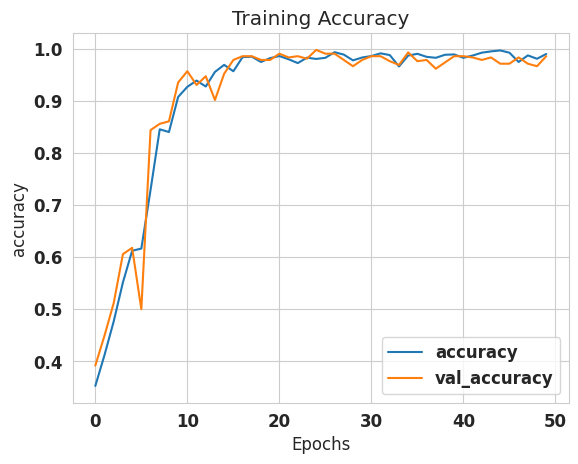

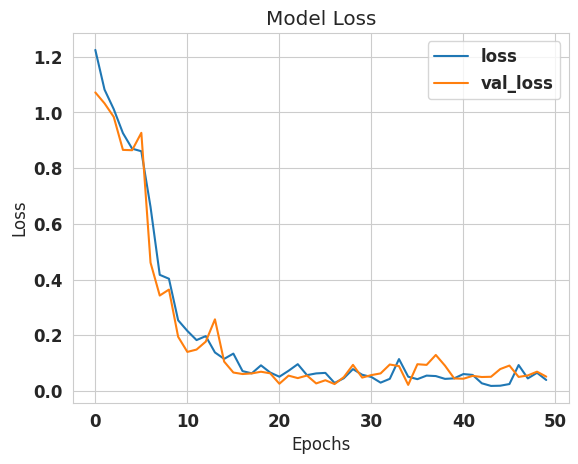

In [40]:
Acc_Loss_Graph(history)

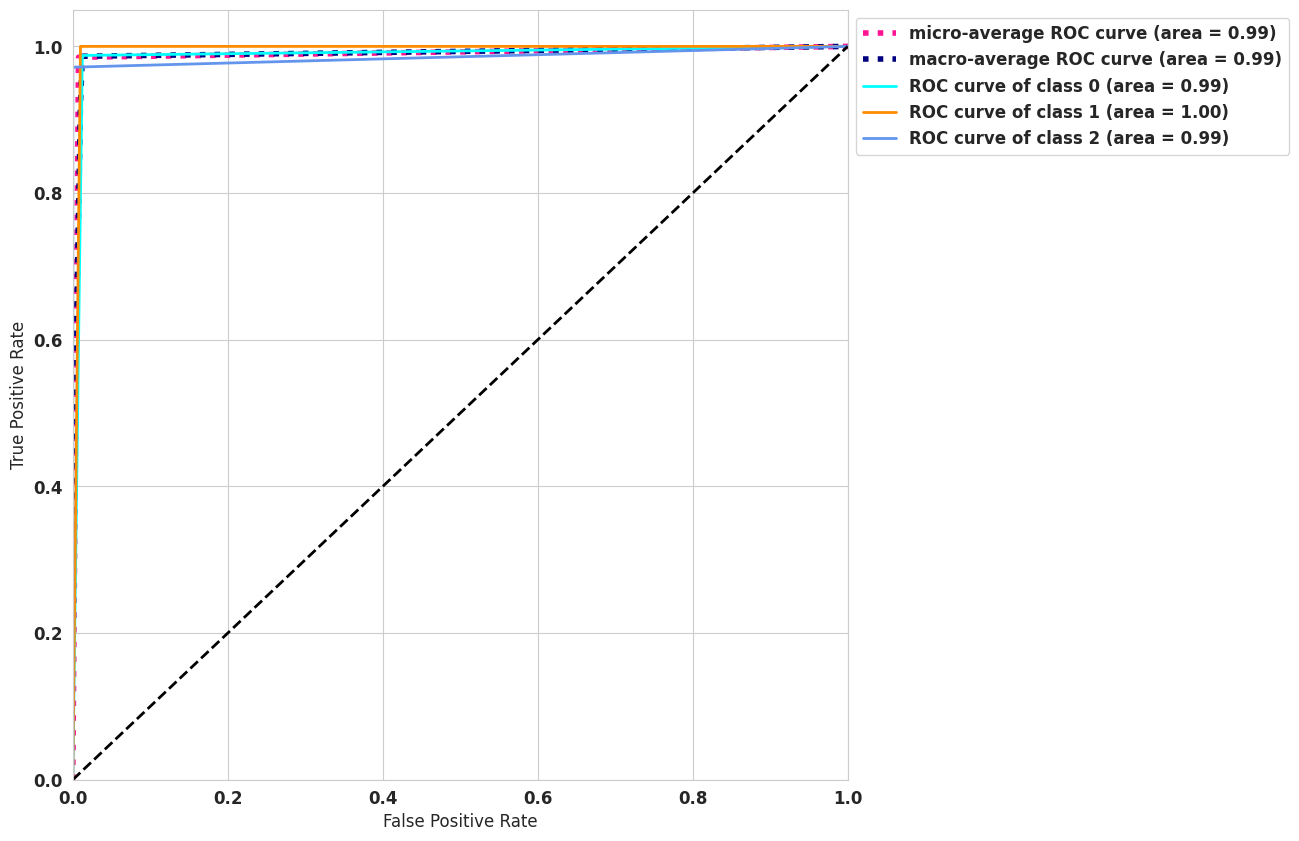

In [41]:
plot_roc_curve(y_test,y_pred2)

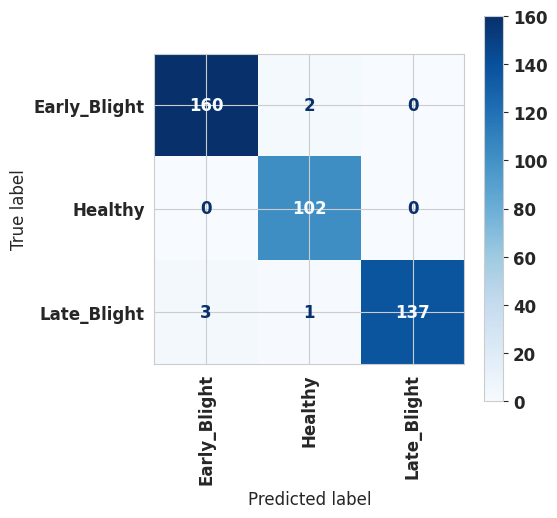

In [42]:
Confusion_Matrix(test_ds.classes , y_pred1)

In [43]:
labels

array(['Early_Blight', 'Healthy', 'Late_Blight'], dtype='<U12')

In [44]:
target_name={0:"Early_Blight",1:"Healthy",2:"Late_Blight"}

In [45]:
from sklearn.manifold import TSNE
tsne1 = TSNE(random_state = 42, n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(y_pred)

In [46]:
# create dataframe
cps_df = pd.DataFrame(columns=['CP1', 'CP2', 'target'],
                       data=np.column_stack((tsne1, 
                                            y_test1)))# cast targets column to int
cps_df.loc[:, 'target'] = cps_df.target.astype(int)
cps_df.loc[:, 'target'] = cps_df.target.map(target_name)

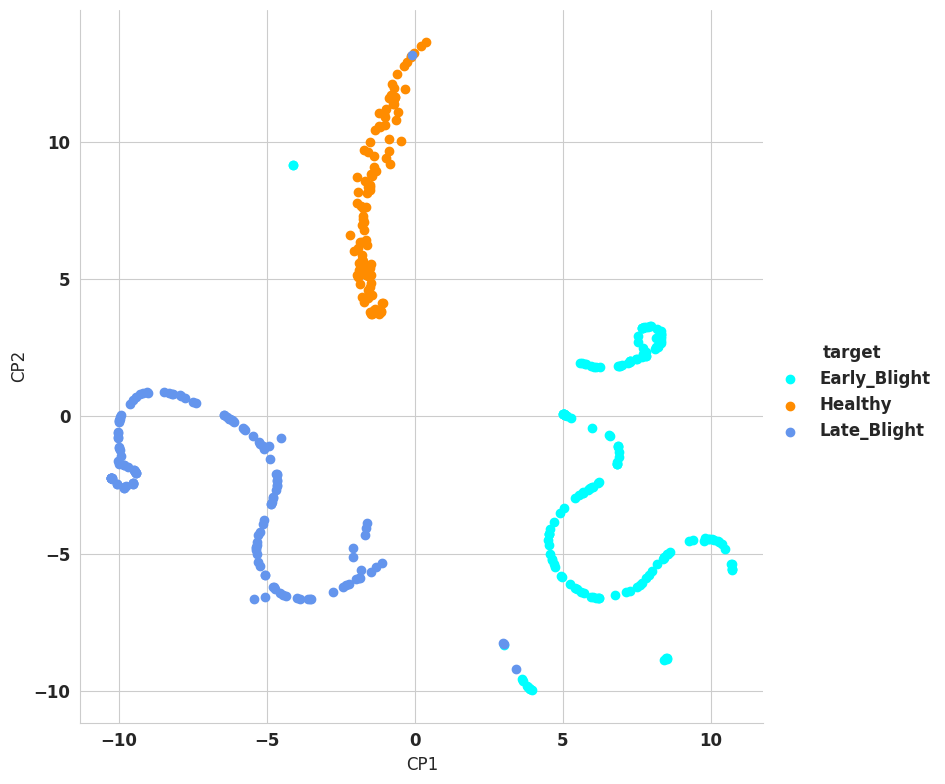

In [47]:
import seaborn as sns
d = {'color': ["aqua", "darkorange", "cornflowerblue",'#9e9e9e','#b19a7e','#CD5C5C','#DFFF00',
                   '#DE3163','#ff4d4d','#CCCCFF','#800080','#4F1D25','#ccffcc','#ff0040'
                   ,'#4000ff','#0080ff','#ff8000','#666600','#b37700','#00b3b3','#003300','#FFC300','#A6F7BD',
                   '#A6BDF7','#CAA6F7','#F7A6AC','#ADF7A6','#F5F7A6','#F7CCA6','#EE4949',
                    '#DEA41F','#334471','#33716F','#343371','#772CE3','#B8BF20','#666B01','#0B6B01',
                    '#F4B708','#179690'] }
grid = sns.FacetGrid(cps_df, hue="target",hue_kws=d, height=8)
grid.map(plt.scatter, 'CP1', 'CP2').add_legend()